In [8]:
import numpy as np
import time
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from utils import trainingData, testingData
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type(torch.DoubleTensor)
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
lb = np.array([-2, -2])
ub = np.array([2, 2])

num_bc = 50
num_f= 5000

import argparse
parser = argparse.ArgumentParser(description='Enter the parameters')
parser.add_argument('-tol','--tol', help='relative tolerance for GMRES', type = float, required=True)
parser.add_argument('-atol','--atol', help='absolute tolerance for GMRES', type = float, required=True)
parser.add_argument('-g_iter','--g_iter', help='maximum iteration within GMRES', type = int, required=True)
args = parser.parse_args(["--tol","5e-4",'--atol',"5e-4",'--g_iter',"5000"])

#args = parser.parse_args(["--lrmax","5e-4",'--lrmin',"5e-4",'--pinn',"3","5",'--dis','4',"50"])
tol = args.tol
atol = args.atol
g_iter = args.g_iter

tol = 1e-7
atol = 1e-20
g_iter =  10
# '
path = f"Poisson/output/1_dis_GACGD_tol_{tol}_atol_{atol}_g_iter_{g_iter}"

# isDirectory = os.path.isdir(path)

# if not os.path.isdir(path):
#     os.makedirs(path)
    
if not os.path.isdir(path + "/history"):
    os.makedirs(path + "/history")
    
if not os.path.isdir(path + "/zz"):
    os.makedirs(path + "/zz")
    
# if not os.path.isdir(path + "/prediction"):
#     os.makedirs(path + "/prediction")'
        
        
        
u = lambda xy: np.sin(xy[:, 0]) * np.cos([xy[:, 1]]) # this cannot be a torch function, otherwise the gradient would be recorded
f = lambda x, y: -2 * np.sin(x) * np.cos(y) #torch->np 
  

RNG_key = 3

all_xy_train, xy_bc, u_bc, xy_inside, f_xy = trainingData(lb, ub, num_bc, num_f, u, f, RNG_key)

u_test_method = lambda x, y: np.sin(x) * np.cos(y) #takes 2 inputs, but should return same values as previous u
x_test, y_test, xy_test, u_test, f_test, X, Y, U = testingData(lb, ub, u_test_method, f, 256)





cpu


c:\Users\natsc\anaconda3\lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


initialize networks

In [9]:
import networks
layers = np.array([2,50 ,50, 50,1])


'ACGD Optimizer'
import CGDs
from training import trainACGD

PINNGACGD = networks.PINN_Poisson_2d(layers, x_test, y_test, u_test, f_test,
                                xy_bc[:,[0]], xy_bc[:,[1]], u_bc, 
                                f_xy, xy_inside[:,[0]], xy_inside[:,[1]], RNG_key)

PINNGACGD.to(device)


D_GACGD = networks.Discriminator(2, 50 ,2)
D_GACGD.to(device)

print(PINNGACGD)
print(D_GACGD)

lr = 0.001

track_cond = lambda x, y:  True
optimizer = CGDs.GACGD(x_params=D_GACGD.parameters(), y_params = PINNGACGD.parameters(), max_iter = g_iter,
            lr_x=lr, lr_y=lr, tol=tol, atol = atol, eps=1e-8, beta=0.99, track_cond = track_cond)




PINN_Poisson_2d(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-2): 2 x Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
Discriminator(
  (map): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)


In [10]:
optimizer = ACGD(max_params=D_GACGD.parameters(), min_params = PINNGACGD.parameters(),
            lr_max=lr, lr_min=lr, tol=tol, atol = atol, eps=1e-8, beta=0.99)# track_cond = track_cond)

In [17]:
import time
import math
import torch
import torch.autograd as autograd

from CGDs.distributed import reduce_mean

from CGDs.cgd_utils import zero_grad, general_conjugate_gradient, Hvp_vec


class ACGD(object):
    def __init__(self, max_params, min_params,
                 max_reducer=None, min_reducer=None,
                 lr_max=1e-3, lr_min=1e-3,
                 eps=1e-5, beta=0.99,
                 tol=1e-12, atol=1e-20,
                 solve_x=False, collect_info=False):
        self.max_reducer = max_reducer
        self.min_reducer = min_reducer
        self.max_params = list(max_params)
        self.min_params = list(min_params)
        self.state = {'lr_max': lr_max, 'lr_min': lr_min,
                      'eps': eps, 'solve_x': solve_x,
                      'tol': tol, 'atol': atol,
                      'beta': beta, 'step': 0,
                      'old_max': None, 'old_min': None,  # start point of CG
                      'sq_exp_avg_max': None, 'sq_exp_avg_min': None}  # save last update
        self.info = {'grad_x': None, 'grad_y': None,
                     'hvp_x': None, 'hvp_y': None,
                     'cg_x': None, 'cg_y': None,
                     'time': 0, 'iter_num': 0}
        self.collect_info = collect_info

    def zero_grad(self):
        zero_grad(self.max_params)
        zero_grad(self.min_params)

    def get_info(self):
        if self.info['grad_x'] is None:
            print('Warning! No update information stored. Set collect_info=True before call this method')
        return self.info

    def state_dict(self):
        return self.state

    def load_state_dict(self, state_dict):
        self.state.update(state_dict)
        print('Load state: {}'.format(state_dict))

    def set_lr(self, lr_max, lr_min):
        self.state.update({'lr_max': lr_max, 'lr_min': lr_min})
        print('Maximizing side learning rate: {:.4f}\n '
              'Minimizing side learning rate: {:.4f}'.format(lr_max, lr_min))

    def step(self, loss, trigger=0.0):
        '''
        '''
        lr_max = self.state['lr_max']
        lr_min = self.state['lr_min']
        beta = self.state['beta']
        eps = self.state['eps']
        tol = self.state['tol']
        atol = self.state['atol']
        time_step = self.state['step'] + 1
        self.state['step'] = time_step
        should_rebuild = time_step < 2

        grad_x = autograd.grad(loss, self.max_params, create_graph=True)
        grad_x_vec = torch.cat([g.contiguous().view(-1) for g in grad_x])
        grad_y = autograd.grad(loss, self.min_params, create_graph=True)
        grad_y_vec = torch.cat([g.contiguous().view(-1) for g in grad_y])

        grad_x_vec_d = grad_x_vec.clone().detach()
        grad_y_vec_d = grad_y_vec.clone().detach()
        # reduce leaf nodes across all devices
        grad_x_vec_d = reduce_mean(grad_x_vec_d)
        grad_y_vec_d = reduce_mean(grad_y_vec_d)

        sq_avg_x = self.state['sq_exp_avg_max']
        sq_avg_y = self.state['sq_exp_avg_min']
        sq_avg_x = torch.zeros_like(grad_x_vec_d, requires_grad=False) if sq_avg_x is None else sq_avg_x
        sq_avg_y = torch.zeros_like(grad_y_vec_d, requires_grad=False) if sq_avg_y is None else sq_avg_y
        sq_avg_x.mul_(beta).addcmul_(grad_x_vec_d, grad_x_vec_d, value=1-beta)
        sq_avg_y.mul_(beta).addcmul_(grad_y_vec_d, grad_y_vec_d, value=1-beta)

        bias_correction = 1 - beta ** time_step
        lr_max = math.sqrt(bias_correction) * lr_max / sq_avg_x.sqrt().add(eps)
        lr_min = math.sqrt(bias_correction) * lr_min / sq_avg_y.sqrt().add(eps)

        scaled_grad_x = torch.mul(lr_max, grad_x_vec_d)
        scaled_grad_y = torch.mul(lr_min, grad_y_vec_d)

        hvp_x_vec = Hvp_vec(grad_y_vec, self.max_params, scaled_grad_y,
                            retain_graph=True,
                            trigger=trigger,
                            rebuild=should_rebuild)  # h_xy * d_y
        hvp_y_vec = Hvp_vec(grad_x_vec, self.min_params, scaled_grad_x,
                            retain_graph=True,
                            trigger=trigger,
                            rebuild=should_rebuild)  # h_yx * d_x
        p_x = torch.add(grad_x_vec_d, - hvp_x_vec)
        p_y = torch.add(grad_y_vec_d, - hvp_y_vec)
        if self.collect_info:
            norm_px = torch.norm(hvp_x_vec, p=2).item()
            norm_py = torch.norm(hvp_y_vec, p=2).item()
            timer = time.time()

   #     if self.state['solve_x']:
        #p_y.mul_(lr_min.sqrt())
        #old_min = cg_y.detach_()
        min_update = p_x.mul( lr_min)
        max_update = p_y.mul(lr_max)
        old_max = p_y.mul(lr_max.sqrt())
        old_min = p_x.mul(lr_min.sqrt())
        # else:
        #     p_x.mul_(lr_max.sqrt())
        #     old_max = cg_x.detach_()
        #     max_update = cg_x.mul(lr_max.sqrt())
        #     min_update = hcg.mul(- lr_min)
        #     old_min = hcg.mul(lr_min.sqrt())
        self.state.update({'old_max': old_max, 'old_min': old_min,
                           'sq_exp_avg_max': sq_avg_x, 'sq_exp_avg_min': sq_avg_y})

        if self.collect_info:
            timer = time.time() - timer
            self.info.update({'time': timer, #'iter_num': iter_num,
                              'hvp_x': norm_px, 'hvp_y': norm_py})

        with torch.no_grad():
            index = 0
            for p in self.max_params:
                p.data.add_(max_update[index: index + p.numel()].reshape(p.shape))
                index += p.numel()
            assert index == max_update.numel(), 'Maximizer CG size mismatch'

            index = 0
            for p in self.min_params:
                p.data.add_(min_update[index: index + p.numel()].reshape(p.shape))
                index += p.numel()
            assert index == min_update.numel(), 'Minimizer CG size mismatch'

        if self.collect_info:
            norm_gx = torch.norm(grad_x_vec, p=2).item()
            norm_gy = torch.norm(grad_y_vec, p=2).item()
            norm_cgx = torch.norm(max_update, p=2).item()
            norm_cgy = torch.norm(min_update, p=2).item()
            self.info.update({'grad_x': norm_gx, 'grad_y': norm_gy,
                              'cg_x': norm_cgx, 'cg_y': norm_cgy})
        self.state['solve_x'] = False if self.state['solve_x'] else True


RuntimeError: The size of tensor a (30802) must match the size of tensor b (5301) at non-singleton dimension 0

forward passes (2 ( CGD) + 5 * 2 (GERM)) + maxiter

forward passes() (2* CGD + 1000 *2) Germ +

optimales germ

In [12]:
10 ** 5 / 12

8333.333333333334

In [13]:
10 ** 5 / ( 17)

5882.35294117647

In [14]:
15 * 10000 

150000

In [15]:
5000 / 12

416.6666666666667

In [16]:
max_iter = 833
recordPer = 1
savePer = 50
graphPer = 0

GACGDInfo = []
iter_num_sum = 0
start_time = time.time()

ACGDInfo = pd.DataFrame()
re_pinn = []
gmre = []
for e in range(max_iter):
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    D_output = D_GACGD(PINNGACGD.x_inside_train, PINNGACGD.y_inside_train) #output[0]=bc, output[1]=inside
    g_pde_diff = PINNGACGD.test_PDE()

    # Optimizer step
    loss1 = D_output[:,[0]] * g_pde_diff
    loss2 = D_GACGD(PINNGACGD.x_bc, PINNGACGD.y_bc)[:,[1]] * (PINNGACGD(PINNGACGD.x_bc, PINNGACGD.y_bc) - PINNGACGD.u_bc)

    loss_y = loss1.mean() + loss2.mean()
    
    loss_x = -loss_y
    #optimizer.step(loss_x, loss_y, 0) #breaks at first step() call
    optimizer.step(loss_y, 0)
    print(e) 
    gmre.append(optimizer.info['num_iter'])



    iter_num_sum += optimizer.info["num_iter"]
    if e % recordPer == 0:
        
    #   losses.append(loss.item())
        g_loss, loss_bc, g_pde_loss = PINNGACGD.loss()
        error_vec, u_pred = PINNGACGD.test(graphPer != 0 and e % graphPer == 0)
        re_pinn.append(g_loss.item())
        ACGDInfo = ACGDInfo.append({
        "iter": e,
        "L2 error": error_vec,
        "PINN loss": g_loss.item(),
        #"PINN BC loss": loss_bc.item(),
        #"PINN PDE loss": g_pde_loss.item(),
        "CPINN loss": loss_y.item(),
       # "CPINN PDE loss": loss1.mean().item(),
        #"CPINN BC loss": loss2.mean().item(),
        "iter_num_sum" : iter_num_sum
        }, ignore_index = True)

    if e % savePer == 0: 
        ACGDInfo.to_csv(f"{path}/history/ACGDInfo_{e}.csv")
       # np.savetxt(f"{path}/prediction/PINNPrediction_iter_{e}.csv", u_pred)
    #     torch.save({
    #         "PINN_state_dict": PINNGACGD.state_dict(),
    #         "Discriminator_state_dict": D_GACGD.state_dict(),
    #         "GACGD_optimizer_state_dict" : optimizer.state_dict(),
    #     }, f"{path}/zz/GACGD_zz_iter_{e}.pt")

print(f"Time: {time.time() - start_time}")

RuntimeError: The size of tensor a (30802) must match the size of tensor b (5301) at non-singleton dimension 0

In [29]:
sum(gmre)

12756

forward passes

In [32]:
300 * 2 + sum(gmre) *2

26112

In [ ]:
ACGDInfo.to_csv(f"{path}/history/ACGDInfo_{e}.csv")
# np.savetxt(f"{path}/prediction/PINNPrediction_iter_{e}.csv", u_pred)
torch.save({
    "PINN_state_dict": PINNGACGD.state_dict(),
    "Discriminator_state_dict": D_GACGD.state_dict(),
    "GACGD_optimizer_state_dict" : optimizer.state_dict(),
}, f"{path}/zz/GACGD_zz_iter_{e}.pt")

In [21]:
5000 / 17

294.11764705882354

In [8]:
#
#GERM 1000 (2* CGD + 1000 *2)

SyntaxError: invalid syntax (4036316084.py, line 2)

In [39]:
# torch.save({
#             "PINN_state_dict": PINNGACGD.state_dict(),
#             "Discriminator_state_dict": D_GACGD.state_dict(),
#             "GACGD_optimizer_state_dict" : optimizer.state_dict(),
#         }, f"{path}/zz/GACGD_zz_iter_{e}.pt")

In [45]:
# num = 2000
# error_vec = np.linalg.norm((self.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(self.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)

In [ ]:
#z_1 = pd.read_csv("D:\\ARBEIT\\pinn\\CPINN\\Poisson\\Poisson\\output\\1_dis_GACGD_tol_1e-07_atol_1e-20_g_iter_1000\\history\\ACGDInfo_1576.csv")

In [49]:

def testingData(lb, ub, u, f, num):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  X=np.linspace(lb[0], ub[0], num)
  Y=np.linspace(lb[1], ub[1], num)
    
  X, Y = np.meshgrid(X,Y) #X, Y are (256, 256) matrices

  U = u(X*Y)
  u_test = U.flatten('F')[:,None]
  u_test = torch.from_numpy(u_test).to(device)
  xy_test = np.hstack((X.flatten('F')[:,None], Y.flatten('F')[:,None]))
  x_test = xy_test[:,[0]]
  y_test = xy_test[:,[1]]
  
  f_test = f(xy_test[:,[0]], xy_test[:,[1]])
  # f_test = torch.from_numpy(f_test).to(device)

  # x_test = torch.from_numpy(xy_test[:,[0]]).to(device)
  # y_test = torch.from_numpy(xy_test[:,[1]]).to(device)
#   f_test = f(x_test, y_test)
  return x_test, y_test, xy_test, u_test, f_test, X, Y, U

In [27]:
hist = ACGDInfo['PINN loss']

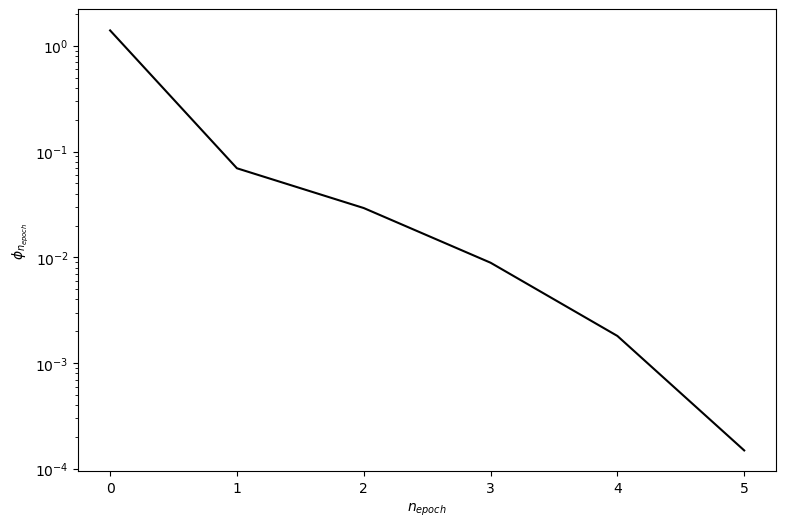

In [46]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [49]:
ACGDInfo["CPINN loss"]

0   -0.008829
1    0.059005
2    0.126907
3    0.137403
4    0.012638
5    0.002526
Name: CPINN loss, dtype: float64

In [50]:
def test(PINN):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    _x = PINN.x_test.clone()
    _y = PINN.y_test.clone()
    _x.requires_grad = True
    _y.requires_grad = True
    
    u_pred = PINN.forward(_x, _y)
    
    test_size = int(np.sqrt(PINN.x_test.shape[0]))


    u_pred = u_pred.cpu().detach().numpy()
    
    error_vec = np.linalg.norm((PINN.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(PINN.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)
    
    u_pred = np.reshape(u_pred, (test_size, test_size), order='F')
    u_test_graph = np.reshape(PINN.u_test.cpu().detach().numpy(),(test_size, test_size), order='F') # make u_test a matrix for graphing

    return error_vec, u_pred

#plot mit PiNN DISC LÖSUNG


$\| NN(x,y) -  u(x,y) \|_2$

In [51]:
test(PINNGACGD)[0]

0.0038046154940228395

In [ ]:
ACGDInfo['PINN loss']

In [1]:
# gs1 = gridspec.GridSpec(1, 3)
# gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

# ax = plt.subplot(gs1[0, 0])
# ax.plot(x,Exact_h[:,75], 'b-', linewidth = 2, label = 'Exact')       
# ax.plot(x,H_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
# ax.set_xlabel('$x$')
# ax.set_ylabel('$|h(t,x)|$')    
# #ax.set_title('$t = %.2f$' % (t[75]), fontsize = 10)
# ax.axis('square')
# ax.set_xlim([-5.1,5.1])
# ax.set_ylim([-0.1,5.1])

In [2]:
def test(PINN, graph = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    _x = PINN.x_test.clone()
    _y = PINN.y_test.clone()
    _x.requires_grad = True
    _y.requires_grad = True
    
    u_pred = PINN.forward(_x, _y)
    
    u_x = torch.autograd.grad(u_pred,_x,torch.ones([_x.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]      
    u_y = torch.autograd.grad(u_pred,_y,torch.ones([_y.shape[0], 1]).to(device), retain_graph= True, create_graph=True)[0]

    u_xx = torch.autograd.grad(u_x, _x, torch.ones((_x.shape[0], 1)).to(device) , retain_graph = True)[0]
    u_yy = torch.autograd.grad(u_y, _y, torch.ones((_y.shape[0], 1)).to(device) , retain_graph = True)[0]

    fxy_test = PINN.f_test
    
    #PDE = u_xx + u_yy - fxy_test
    
    test_size = int(math.sqrt(PINN.x_test.shape[0]))
    
    #PDE = PDE.cpu().detach().numpy()
    
   # PDE = np.reshape(PDE, (test_size, test_size), order='F') #PDE is a 256*256 matrix now

    u_pred = u_pred.cpu().detach().numpy()
    
    error_vec = np.linalg.norm((PINN.u_test.cpu().detach().numpy() - u_pred),2) / np.linalg.norm(PINN.u_test.cpu().detach().numpy(), 2)  # Relative L2 Norm of the error (Vector)
    
    u_pred = np.reshape(u_pred, (test_size, test_size), order='F')
    u_test_graph = np.reshape(PINN.u_test.cpu().detach().numpy(),(test_size, test_size), order='F') # make u_test a matrix for graphing
    if (graph):
        fig, ax = plt.subplots(1, 3,figsize=(30,4))
        
        im1 = ax[0].imshow(u_test_graph, interpolation='nearest', cmap='rainbow', 
#                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
                    origin='lower', aspect='equal')
        fig.colorbar(im1, ax = ax[0])
        
        im2 = ax[1].imshow(u_pred, interpolation='nearest', cmap='rainbow', 
#                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
                    origin='lower', aspect='equal')
        fig.colorbar(im2, ax = ax[1])
        
        im3 = ax[2].imshow(u_pred - u_test_graph, interpolation='nearest', cmap='bwr', 
#                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
                    origin='lower', aspect='equal')
        fig.colorbar(im3, ax=ax[2])
        
#         im4 = ax[3].imshow(PDE, interpolation='nearest', cmap='bwr', 
# #                       extent=[PINN.y_test.min(), PINN.y_test.max(), PINN.x_test.min(), PINN.x_test.max()], 
#                     origin='lower', aspect='equal')


        ax[0].set_title('True $u(x,y)$', fontsize = 10)
        ax[1].set_title('Predicted $u(x,y)$', fontsize = 10)
        ax[2].set_title('Difference', fontsize = 10)
       # ax[3].set_title('PDE diff', fontsize = 10)

        fig.colorbar(im4, ax = ax[3])
        plt.show()
    return error_vec, u_pred

In [ ]:
import math
test(PINNGACGD,True)